In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pulsar_stars.csv')
print(df.columns)
print(df.describe())

Index(['Mean_of_the_integrated_profile',
       'Standard_deviation_of_the_integrated_profile',
       'Excess_kurtosis_of_the_integrated_profile',
       'Skewness_of_the_integrated_profile', 'Mean_of_the_DM_SNR_curve',
       'Standard_deviation_of_the_DM_SNR_curve',
       ' Excess_kurtosis_of_the_DM_SNR_curve', ' Skewness_of_the_DM_SNR_curve',
       'target_class'],
      dtype='object')
       Mean_of_the_integrated_profile  \
count                    17898.000000   
mean                       111.079968   
std                         25.652935   
min                          5.812500   
25%                        100.929688   
50%                        115.078125   
75%                        127.085938   
max                        192.617188   

       Standard_deviation_of_the_integrated_profile  \
count                                  17898.000000   
mean                                      46.549532   
std                                        6.843189   
min           

In [ ]:
X = df.drop(['target_class'], axis=1)
y = df['target_class']
print(df['target_class'].value_counts())

0    16259
1     1639
Name: target_class, dtype: int64


In [ ]:
class SVM:
  def __init__(self, iterations=100, lr = 0.0001, lamda = 0.01):
    self.iterations = iterations
    self.lr = lr
    self.lamda = lamda
    self.w = None
    self.b = None

  def init_parameters(self, X):
    self.w = np.zeros(X.shape[1])
    self.b = 0

  def gradient_descent(self, X, y):
    y_temp = np.where(y <= 0, -1, 1)
    for (i, data) in enumerate(X):
      if y_temp[i] * (np.dot(data, self.w) - self.b) >= 1:
        dw = 2 * self.lamda * self.w
        db = 0
      else:
        dw = 2 * self.lamda * self.w - np.dot(data, y_temp[i])
        db = y_temp[i]
      self.update_parameters(dw, db)

  def update_parameters(self, dw, db):
    self.w -= self.lr * dw
    self.b -= self.lr * db

  def fit(self, X, y):
    if isinstance(X, pd.DataFrame):
      X = X.values
    if isinstance(y, pd.Series):
      y = y.values
    self.init_parameters(X)
    for _ in range(self.iterations):
      self.gradient_descent(X, y)


  def predict(self, X):
    output = np.dot(X, self.w) - self.b
    return np.where(output <= 0, 0, 1)


In [ ]:
from sklearn.model_selection import KFold, train_test_split
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import matplotlib.pyplot as plt

def train_model(model, X, y, n_splits):
  k_flod = KFold(n_splits=n_splits, shuffle=True)
  # print(model)
  train_res = []
  test_res = []
  for i, (train_id, test_id) in enumerate(k_flod.split(X)):
    model.fit(X.loc[train_id], y[train_id])
    y_pred = model.predict(X.loc[train_id])
    train_res.append((y[train_id] == y_pred).sum() / len(y_pred))
    y_pred = model.predict(X.loc[test_id])
    test_res.append((y[test_id] == y_pred).sum() / len(y_pred))
  plt.figure(figsize=(12,8))
  plt.title('Train Accuracy')
  ax = sns.barplot(x=[i+1 for i in range(n_splits)], y=train_res, legend='full')
  ax.bar_label(ax.containers[0], fontsize=10);
  plt.xlabel('KFlods')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.figure(figsize=(12,8))
  plt.title('Test Accuracy')
  ax = sns.barplot(x=[i+1 for i in range(n_splits)], y=test_res, legend='full')
  ax.bar_label(ax.containers[0], fontsize=10);
  plt.xlabel('KFlods')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

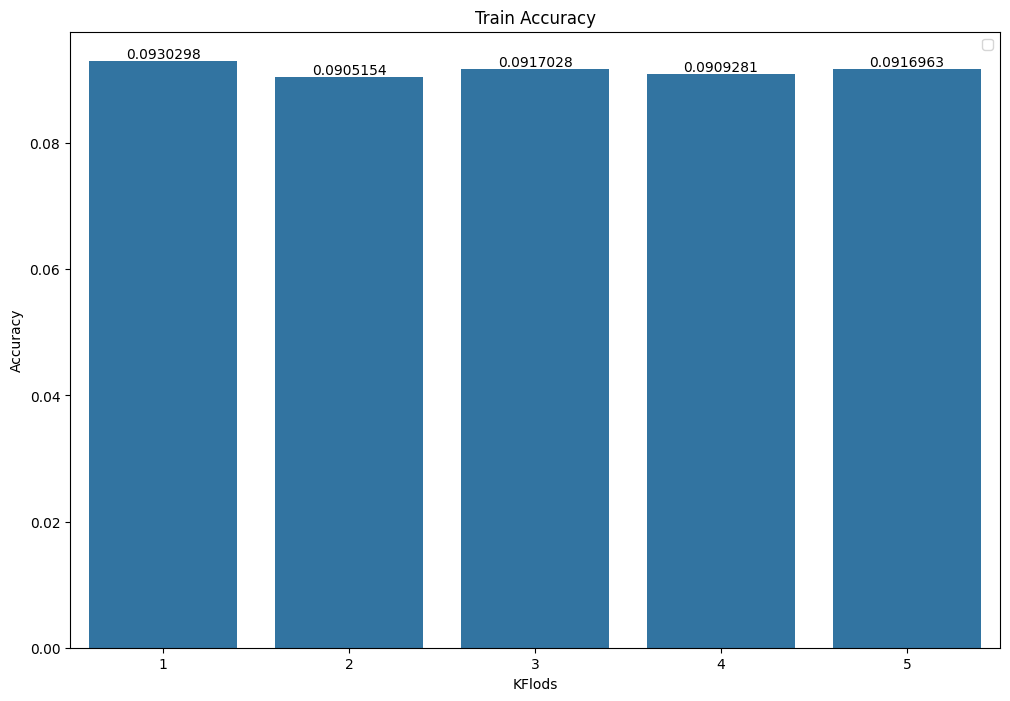

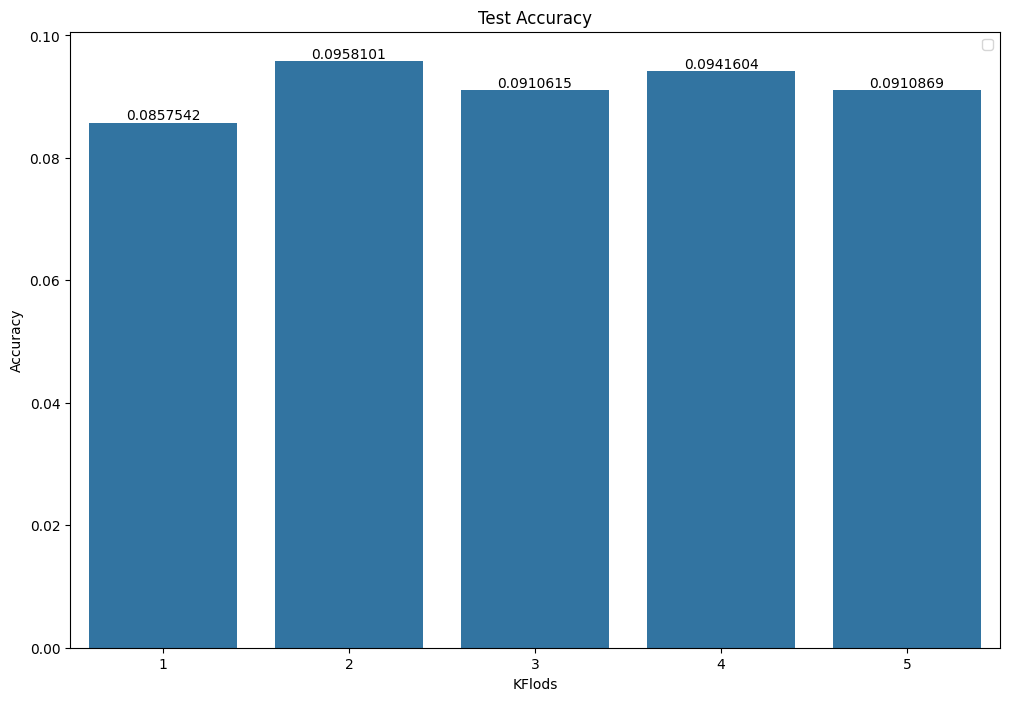

In [ ]:
X = df.drop(['target_class'], axis=1)
y = df['target_class']
train_model(SVM(), X, y, 5)

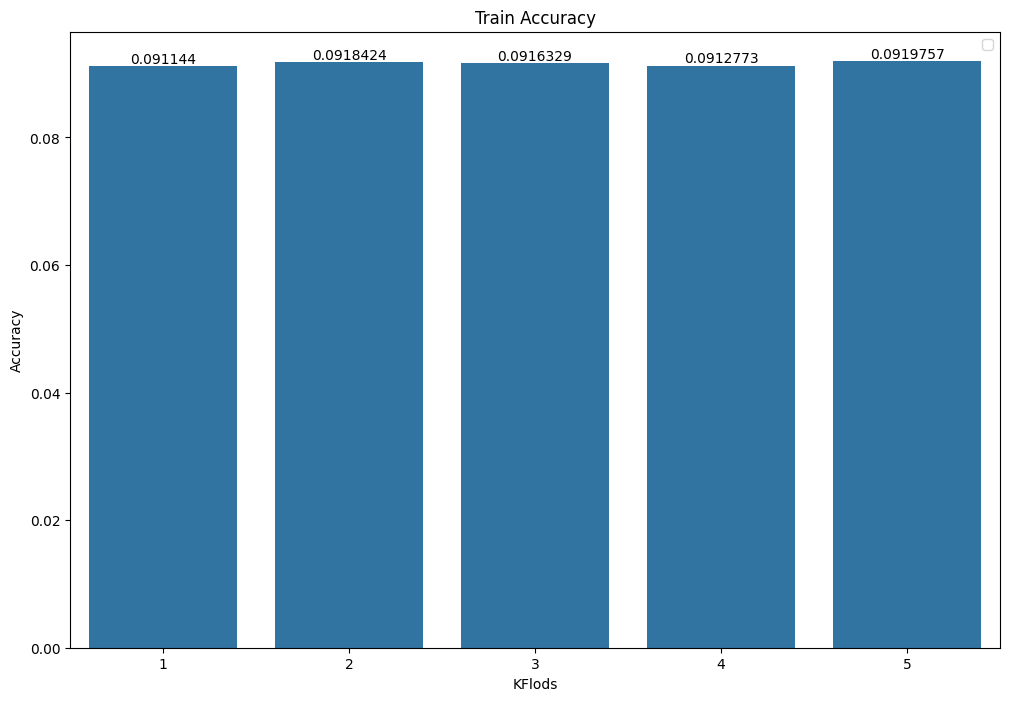

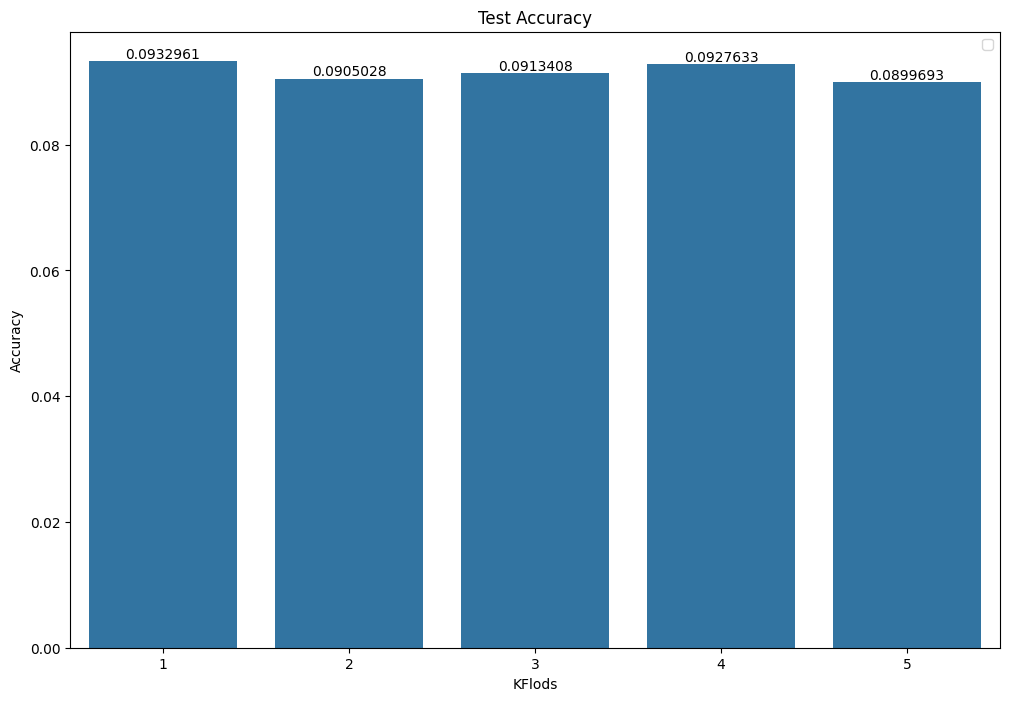

In [ ]:
train_model(SVM(iterations=2000), X, y, 5)

In [ ]:
class SVM_soft_margin():
  def __init__(self, iterations=100, alpha=0.001, lamda=0.01):
    self.iterations = iterations
    self.alpha = alpha
    self.lamda = lamda
    self.w = None
    self.b = None

  def fit(self, X, y):
    n_samples, n_features = X.shape
    if isinstance(X, pd.DataFrame):
      X = X.values
    if isinstance(y, pd.Series):
      y = y.values
    self.w = np.zeros(n_features)
    self.b = 0
    for iteration in range(self.iterations):
      for (i, x) in enumerate(X):
        if y[i] * (np.dot(x, self.w) - self.b) >= 1:
          self.w -= self.alpha * (2 * self.lamda * self.w)
        else:
          self.w -= self.alpha * (2 * self.lamda * self.w - np.dot(x, y[i]))
          self.b -= self.alpha * y[i]

  def predict(self, X):
    pred = np.dot(X, self.w) - self.b
    return np.where(pred > 0, 1, 0)



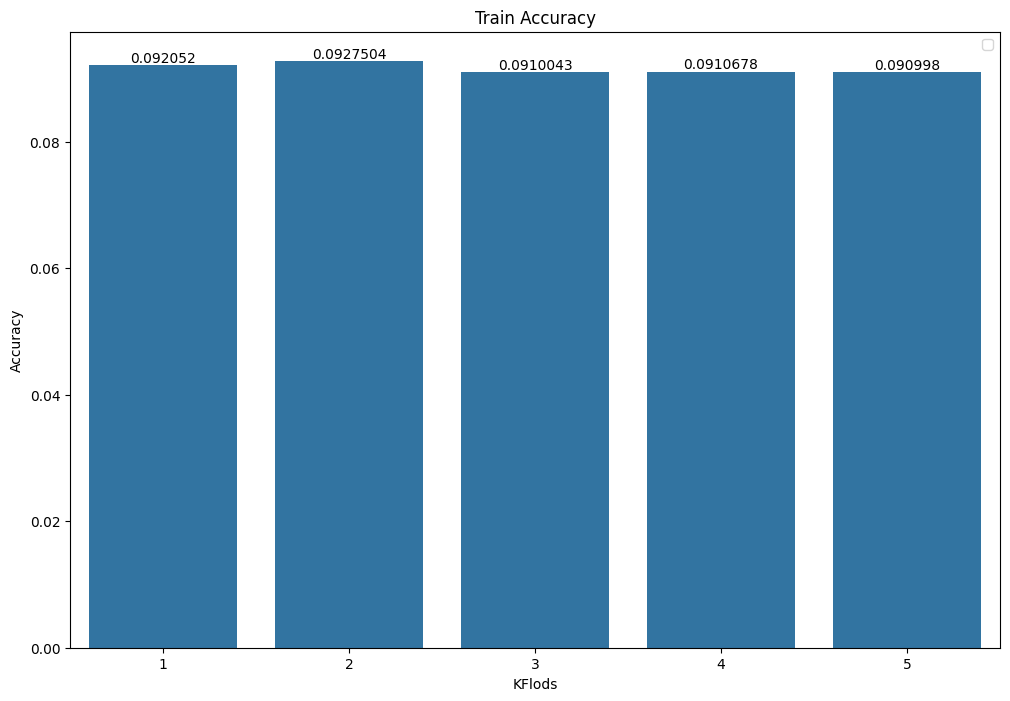

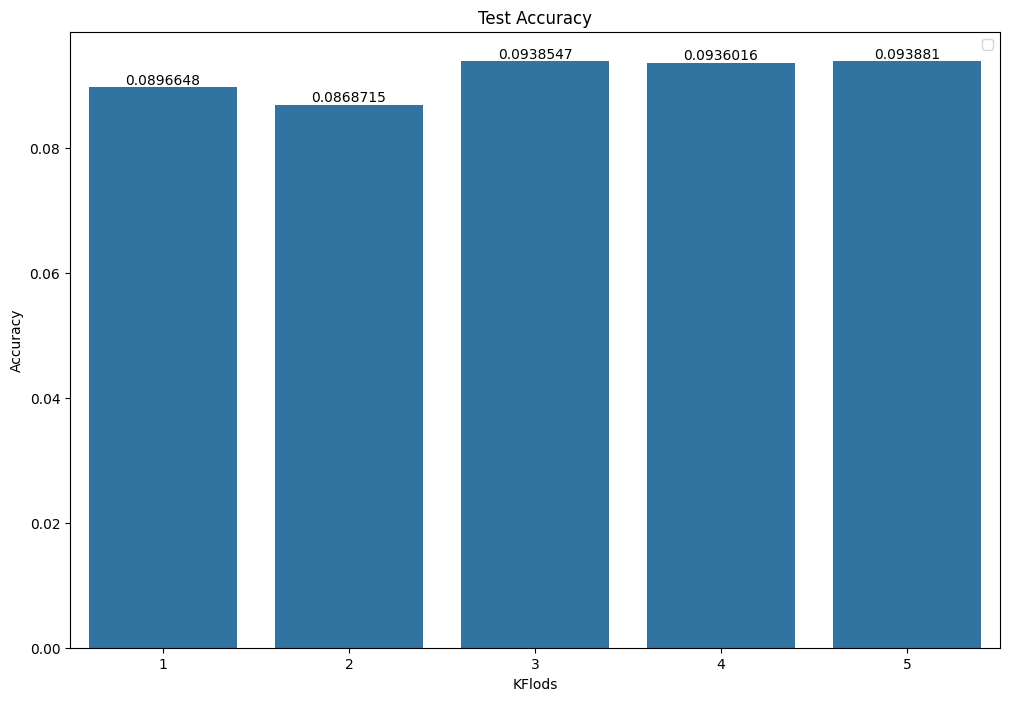

In [ ]:
train_model(SVM_soft_margin(iterations=200), X, y, 5)

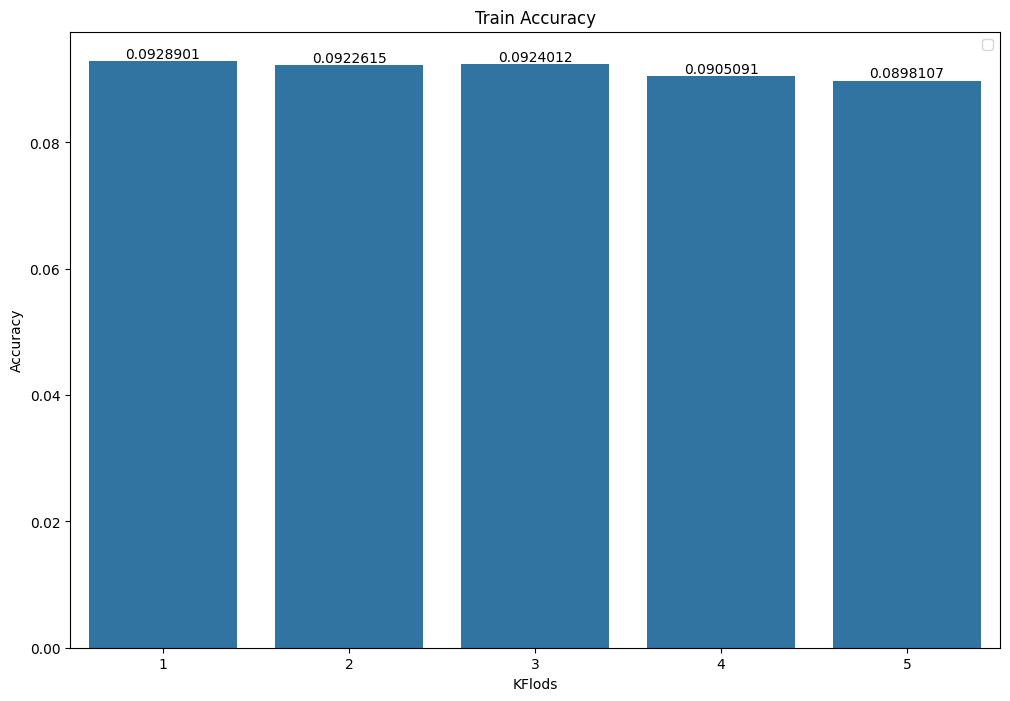

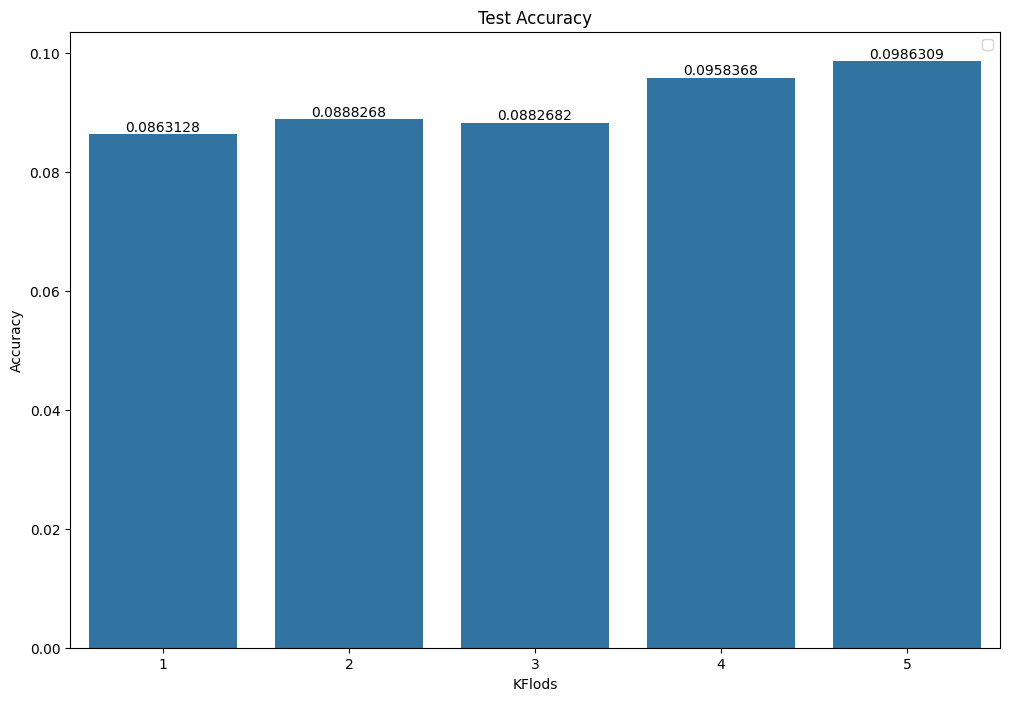

In [ ]:
  train_model(SVM_soft_margin(iterations=2000), X, y, 5)

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_model(model, X, y, n_splits):
  k_flod = KFold(n_splits=n_splits)
  # print(model)

  train_res = []
  test_res = []
  for i, (train_id, test_id) in enumerate(k_flod.split(X)):
    model.fit(X.loc[train_id], y[train_id])
    y_pred = model.predict(X.loc[train_id], 0.5)
    classes = ['Class 0', 'Class 1']
    print("F1 score:", f1_score(y[train_id], y_pred))
    plot_confusion_matrix(confusion_matrix(y[train_id], y_pred), normalize=True, classes=classes)
    break
X = df.drop(['target_class'], axis=1)
y = df['target_class']
train_model(SVM_soft_margin(iterations=200), X, y, 5)

TypeError: SVM_soft_margin.predict() takes 2 positional arguments but 3 were given